# TITLE
## Summer 2024 Data Science Project

**By Matvey Lyapin**

### Introduction

### Data Curation

In [151]:
## Import important stuff.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # for nice-lookin plots
import scipy.stats as statsim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [238]:
xlsx = pd.ExcelFile("datasets/whr/src/WHR_Tab2.1.xls")
whole_whr = pd.read_excel(xlsx, "Sheet1")
print(whole_whr.to_string())

                   Country name  year  Life Ladder  Log GDP per capita  Social support  Healthy life expectancy at birth  Freedom to make life choices  Generosity  Perceptions of corruption  Positive affect  Negative affect
0                   Afghanistan  2008     3.723590            7.350416        0.450662                         50.500000                      0.718114    0.164055                   0.881686         0.414297         0.258195
1                   Afghanistan  2009     4.401778            7.508646        0.552308                         50.799999                      0.678896    0.187297                   0.850035         0.481421         0.237092
2                   Afghanistan  2010     4.758381            7.613900        0.539075                         51.099998                      0.600127    0.117861                   0.706766         0.516907         0.275324
3                   Afghanistan  2011     3.831719            7.581259        0.521104                  

In [6]:
whr = whole_whr[['Country name', 'year', 'Life Ladder']]
print(whr)

     Country name  year  Life Ladder
0     Afghanistan  2008     3.723590
1     Afghanistan  2009     4.401778
2     Afghanistan  2010     4.758381
3     Afghanistan  2011     3.831719
4     Afghanistan  2012     3.782938
...           ...   ...          ...
2358     Zimbabwe  2019     2.693523
2359     Zimbabwe  2020     3.159802
2360     Zimbabwe  2021     3.154578
2361     Zimbabwe  2022     3.296220
2362     Zimbabwe  2023     3.572386

[2363 rows x 3 columns]


### Exploratory Data Analysis

### Primary Analysis

In [235]:
class HapModel:
    def __init__(self, country):
        country_whr = whr[whr['Country name'] == country]

        self.name = country
        self.X = country_whr['year'].to_numpy().reshape(-1, 1)
        self.y = country_whr['Life Ladder'].to_numpy().reshape(-1, 1)
        self.model = LinearRegression().fit(self.X, self.y)
        self.y_pred = self.model.predict(self.X)
        self.mse = mean_squared_error(self.y, self.y_pred)
        self.r2 = r2_score(self.y, self.y_pred)

    def transform_axes(self, axes):
        axes.scatter(self.X, self.y, color='blue', label='Data')
        axes.plot(self.X, self.y_pred, color='red', label='Linear Regression')
        axes.xaxis.set_major_locator(MaxNLocator(integer=True))
        axes.set_title(f'{self.name}\'s Life Ladder Over Time')
        axes.set_ylabel('Life Ladder Score')
        axes.set_xlabel('Year')
        axes.legend()

    def report(self):
        fig, axes = plt.subplots()
        self.transform_axes(axes)

        plt.show()
        print(f'{self.name} regression performance metrics:')
        print(f' - MSE: {self.mse}')
        print(f' - R2: {self.r2}')
    
    def predict_happiness(self, year):
        print(f'In {year}, {self.name}\'s Life Ladder score is projected to be {self.model.predict([[year]]).clip(min=0)[0][0]}!')

In [ ]:
#gwhr = whr[whr['year'] >= 2022].groupby(['Country name']).count()

In [224]:
def get_prediction_table(year):
    gwhr = whr.groupby(['Country name']).count()
    slr_whr_countries = gwhr[gwhr['Life Ladder'] >= 2]
    slindex = slr_whr_countries.index.to_numpy()
    d = {
        'Country name': slindex,
        f'Predicted Life Ladder in {year}': (np.vectorize(lambda x: HapModel(x).predict_happiness(year)))(slindex),
        'R2 of Regression': (np.vectorize(lambda x: HapModel(x).r2))(slindex), 'Data Points Used': (np.vectorize(lambda x: HapModel(x).X.size))(slindex)
        }

    result = pd.DataFrame(d).sort_values(by=[f'Predicted Life Ladder in {year}'], ascending=False).reset_index(drop=True)
    result.index += 1
    return result

pt = get_prediction_table(2026)
len(pt)

160

In [225]:
tpt = pt[pt['R2 of Regression'] >= 0.5]
len(tpt)

53

In [226]:
print(tpt.head(20).to_string())

                Country name  Predicted Life Ladder in 2026  R2 of Regression  Data Points Used
12                 Australia                       7.052777          0.587066                17
13                   Czechia                       7.013714          0.578525                15
15                    Serbia                       6.915463          0.887250                16
16                   Romania                       6.909833          0.797432                17
17                 Lithuania                       6.867630          0.624491                18
18                    Kosovo                       6.857168          0.570424                17
19                    Canada                       6.856851          0.730087                18
20                 Nicaragua                       6.836127          0.775525                18
21                  Slovenia                       6.832096          0.657631                16
22                   Uruguay            

In [227]:
print(tpt.tail(20).to_string())

                 Country name  Predicted Life Ladder in 2026  R2 of Regression  Data Points Used
92                    Georgia                       5.477438          0.899831                18
96                   Cameroon                       5.305192          0.550786                18
98                     Belize                       5.107079          1.000000                 2
115                      Togo                       4.677909          0.702543                12
134                    Jordan                       3.813420          0.769351                18
140                     India                       3.485097          0.588740                18
144                  Eswatini                       3.305646          0.822933                 4
145          Congo (Kinshasa)                       3.260639          0.528265                10
148                    Malawi                       3.053377          0.519241                15
150                  Botswana 

### Visualization

In [228]:
def ploteroo(num_plots, df):
  country_list = df.head(num_plots)['Country name'].to_list()
  fig, axes = plt.subplots(1,num_plots, figsize=(15, 5))

  for i in range(len(country_list)):
    HapModel(country_list[i]).transform_axes(axes[i])

  plt.tight_layout()
  plt.show()

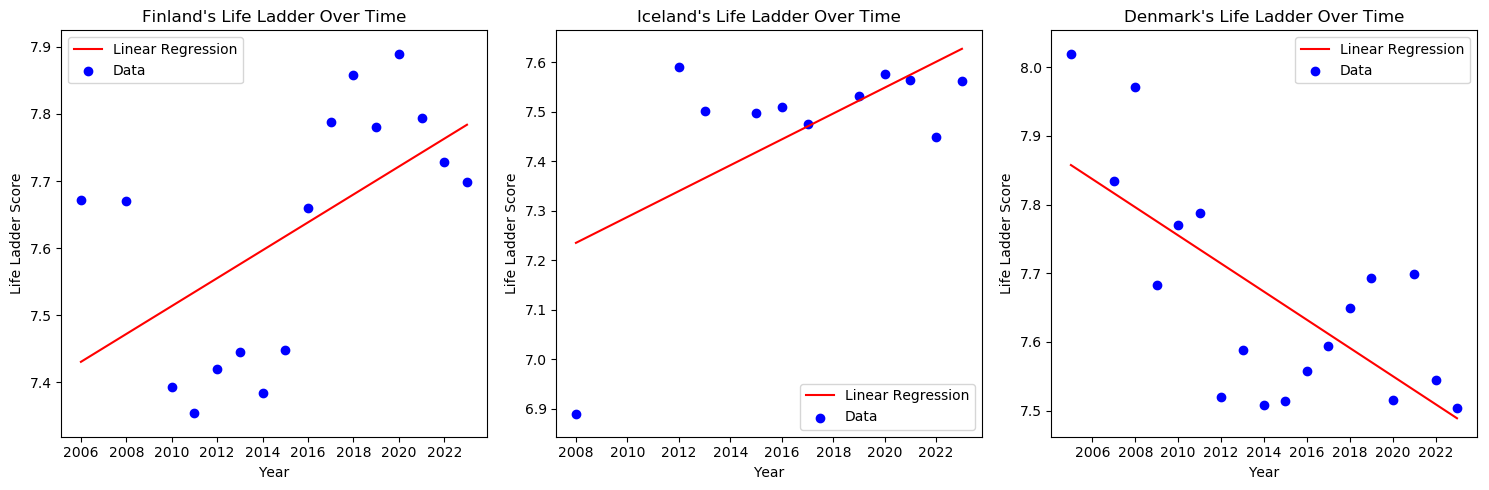

In [229]:
ploteroo(3, pt)

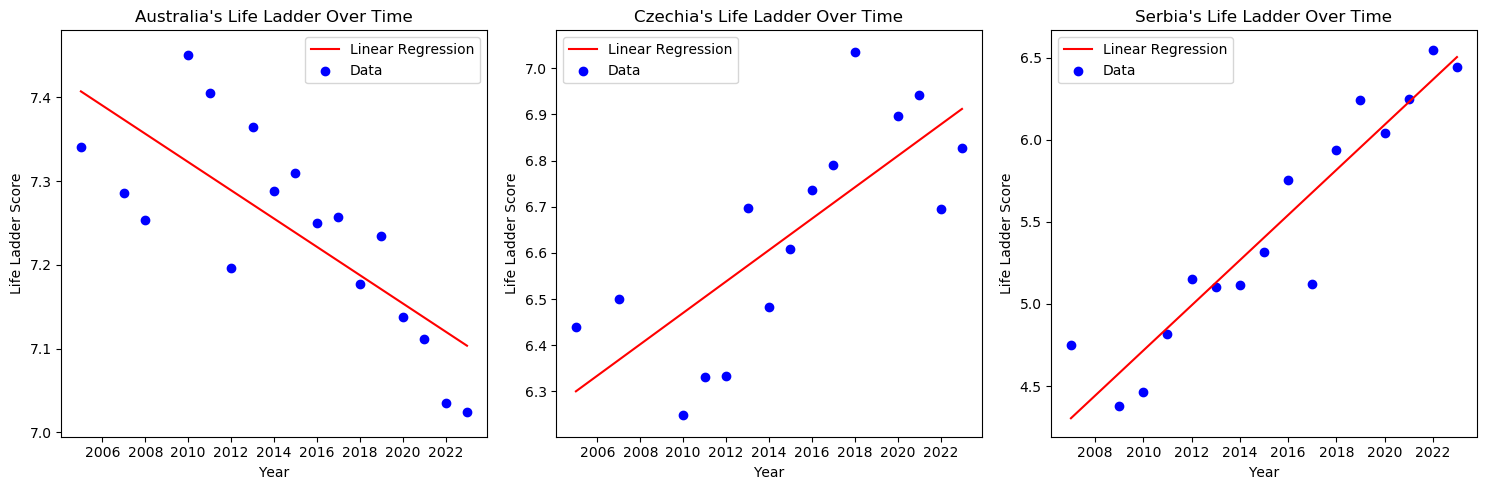

In [230]:
ploteroo(3, tpt)

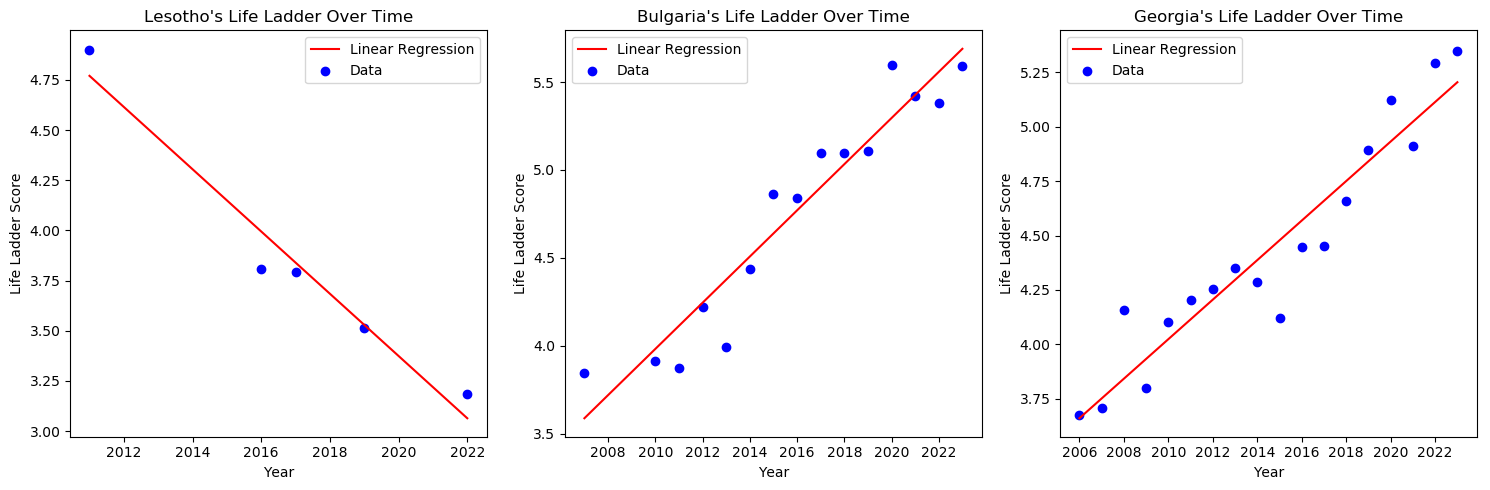

In [237]:
ploteroo(3, tpt[tpt['Data Points Used'] >= 5].sort_values(by=['R2 of Regression'], ascending= False))

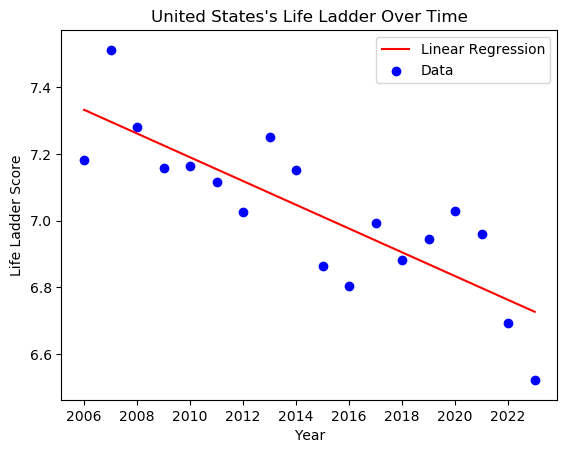

United States regression performance metrics:
 - MSE: 0.01636995950222191
 - R2: 0.6763296311460378
In 2026, United States's Life Ladder score is projected to be 6.61919877141213!


In [236]:
h1 = HapModel('United States')
h1.report()
h1.predict_happiness(2026)

### Insights and Conclusions